In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Session 9-20230630T041341Z-001/Session 9/

/content/gdrive/My Drive/Session 9-20230630T041341Z-001/Session 9


# Imports

In [3]:
from model import Net

In [4]:
import utils as utils

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Dataset, Transforms

In [6]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


# Dataset and Creating Train/Test Split

In [7]:
mu = (0.49139968, 0.48215827, 0.44653124)
sigma = (0.24703233, 0.24348505, 0.26158768)

batch_size = 256
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

UnNorm = utils.UnNormalize(mu, sigma)

In [8]:
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation('Visualization', mu, sigma))
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified


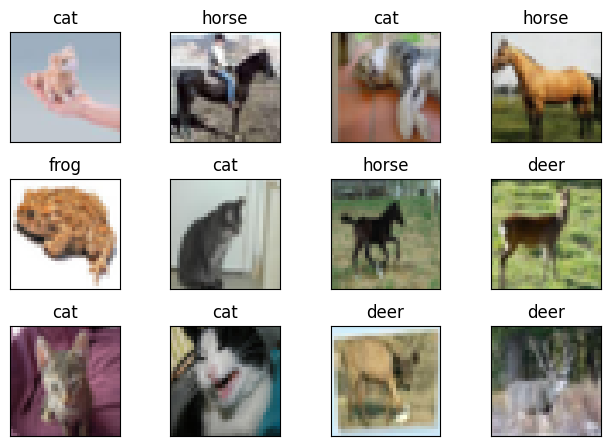

In [9]:
batch_data, batch_label = next(iter(test_loader))
utils.show_examples_dataset_cifar10(batch_data, batch_label)

In [10]:
train_data = utils.Cifar10SearchDataset(root='./data', train=True, download=True, transform=utils.augmentation('Train', mu, sigma))
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation('Test', mu, sigma))

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [11]:
model = Net().to(device)
utils.show_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,728
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 24, 24]          36,864
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 64, 24, 24]             640
            Conv2d-8           [-1, 64, 24, 24]           4,160
depthwise_separable_conv-9           [-1, 64, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]          36,864
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 64, 24, 24]          36,864
      BatchNorm2d-14           [-

# Training

In [12]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)
    loss = criterion(y_pred, target)
    train_loss += loss
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader.dataset)

  return train_loss.cpu().detach().numpy(), 100*correct/processed


def test(model, device, test_loader, criterion):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss.cpu().detach().numpy(), 100. * correct / len(test_loader.dataset)


In [42]:
num_epochs = 200

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=15, steps_per_epoch=len(train_loader))

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
  test_loss, test_acc = test(model, device, test_loader, criterion)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  scheduler.step()

Epoch 1


Loss=1.6932497024536133 Batch_id=195 Accuracy=29.50: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s]



Test set: Average loss: 0.0060, Accuracy: 4388/10000 (43.88%)

Epoch 2


Loss=1.6327736377716064 Batch_id=195 Accuracy=40.74: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]



Test set: Average loss: 0.0059, Accuracy: 4701/10000 (47.01%)

Epoch 3


Loss=1.5766804218292236 Batch_id=195 Accuracy=45.26: 100%|██████████| 196/196 [00:17<00:00, 11.51it/s]



Test set: Average loss: 0.0047, Accuracy: 5733/10000 (57.33%)

Epoch 4


Loss=1.2287464141845703 Batch_id=195 Accuracy=49.22: 100%|██████████| 196/196 [00:16<00:00, 11.65it/s]



Test set: Average loss: 0.0047, Accuracy: 5785/10000 (57.85%)

Epoch 5


Loss=1.2798610925674438 Batch_id=195 Accuracy=51.47: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0045, Accuracy: 6007/10000 (60.07%)

Epoch 6


Loss=1.3810104131698608 Batch_id=195 Accuracy=53.20: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0042, Accuracy: 6295/10000 (62.95%)

Epoch 7


Loss=1.1145904064178467 Batch_id=195 Accuracy=55.07: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0040, Accuracy: 6443/10000 (64.43%)

Epoch 8


Loss=1.200549840927124 Batch_id=195 Accuracy=56.29: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0037, Accuracy: 6743/10000 (67.43%)

Epoch 9


Loss=1.1104029417037964 Batch_id=195 Accuracy=56.82: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0037, Accuracy: 6800/10000 (68.00%)

Epoch 10


Loss=1.2154853343963623 Batch_id=195 Accuracy=58.42: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]



Test set: Average loss: 0.0035, Accuracy: 6951/10000 (69.51%)

Epoch 11


Loss=1.000766634941101 Batch_id=195 Accuracy=59.49: 100%|██████████| 196/196 [00:15<00:00, 12.27it/s]



Test set: Average loss: 0.0033, Accuracy: 7050/10000 (70.50%)

Epoch 12


Loss=1.2257726192474365 Batch_id=195 Accuracy=60.34: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s]



Test set: Average loss: 0.0032, Accuracy: 7211/10000 (72.11%)

Epoch 13


Loss=1.2777727842330933 Batch_id=195 Accuracy=60.53: 100%|██████████| 196/196 [00:16<00:00, 12.02it/s]



Test set: Average loss: 0.0037, Accuracy: 6827/10000 (68.27%)

Epoch 14


Loss=1.1686646938323975 Batch_id=195 Accuracy=61.62: 100%|██████████| 196/196 [00:16<00:00, 11.58it/s]



Test set: Average loss: 0.0032, Accuracy: 7300/10000 (73.00%)

Epoch 15


Loss=1.1370140314102173 Batch_id=195 Accuracy=62.10: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0032, Accuracy: 7223/10000 (72.23%)

Epoch 16


Loss=1.1861376762390137 Batch_id=195 Accuracy=62.81: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0030, Accuracy: 7388/10000 (73.88%)

Epoch 17


Loss=1.1188970804214478 Batch_id=195 Accuracy=62.80: 100%|██████████| 196/196 [00:16<00:00, 11.62it/s]



Test set: Average loss: 0.0029, Accuracy: 7487/10000 (74.87%)

Epoch 18


Loss=0.9626303911209106 Batch_id=195 Accuracy=63.85: 100%|██████████| 196/196 [00:16<00:00, 11.83it/s]



Test set: Average loss: 0.0029, Accuracy: 7437/10000 (74.37%)

Epoch 19


Loss=0.9068927764892578 Batch_id=195 Accuracy=64.26: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0028, Accuracy: 7608/10000 (76.08%)

Epoch 20


Loss=1.0671377182006836 Batch_id=195 Accuracy=64.77: 100%|██████████| 196/196 [00:17<00:00, 11.18it/s]



Test set: Average loss: 0.0028, Accuracy: 7626/10000 (76.26%)

Epoch 21


Loss=0.9661690592765808 Batch_id=195 Accuracy=64.97: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0028, Accuracy: 7563/10000 (75.63%)

Epoch 22


Loss=0.9078267812728882 Batch_id=195 Accuracy=65.38: 100%|██████████| 196/196 [00:16<00:00, 11.93it/s]



Test set: Average loss: 0.0029, Accuracy: 7452/10000 (74.52%)

Epoch 23


Loss=1.081302285194397 Batch_id=195 Accuracy=65.45: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]



Test set: Average loss: 0.0028, Accuracy: 7511/10000 (75.11%)

Epoch 24


Loss=0.8989014625549316 Batch_id=195 Accuracy=65.84: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s]



Test set: Average loss: 0.0030, Accuracy: 7439/10000 (74.39%)

Epoch 25


Loss=0.9484240412712097 Batch_id=195 Accuracy=66.42: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]



Test set: Average loss: 0.0027, Accuracy: 7666/10000 (76.66%)

Epoch 26


Loss=1.069461464881897 Batch_id=195 Accuracy=67.10: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0028, Accuracy: 7589/10000 (75.89%)

Epoch 27


Loss=1.305359125137329 Batch_id=195 Accuracy=67.54: 100%|██████████| 196/196 [00:17<00:00, 11.32it/s]



Test set: Average loss: 0.0026, Accuracy: 7726/10000 (77.26%)

Epoch 28


Loss=0.9500773549079895 Batch_id=195 Accuracy=67.14: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0024, Accuracy: 7848/10000 (78.48%)

Epoch 29


Loss=0.9203370809555054 Batch_id=195 Accuracy=67.47: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0030, Accuracy: 7373/10000 (73.73%)

Epoch 30


Loss=1.0185205936431885 Batch_id=195 Accuracy=68.10: 100%|██████████| 196/196 [00:16<00:00, 11.64it/s]



Test set: Average loss: 0.0024, Accuracy: 7888/10000 (78.88%)

Epoch 31


Loss=1.1230800151824951 Batch_id=195 Accuracy=67.79: 100%|██████████| 196/196 [00:16<00:00, 11.62it/s]



Test set: Average loss: 0.0026, Accuracy: 7749/10000 (77.49%)

Epoch 32


Loss=1.1366825103759766 Batch_id=195 Accuracy=68.22: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0025, Accuracy: 7844/10000 (78.44%)

Epoch 33


Loss=0.8353127241134644 Batch_id=195 Accuracy=68.20: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0024, Accuracy: 7917/10000 (79.17%)

Epoch 34


Loss=0.7967217564582825 Batch_id=195 Accuracy=68.36: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0025, Accuracy: 7941/10000 (79.41%)

Epoch 35


Loss=0.9970535039901733 Batch_id=195 Accuracy=68.86: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]



Test set: Average loss: 0.0023, Accuracy: 8020/10000 (80.20%)

Epoch 36


Loss=0.9555011987686157 Batch_id=195 Accuracy=68.92: 100%|██████████| 196/196 [00:16<00:00, 12.16it/s]



Test set: Average loss: 0.0023, Accuracy: 8087/10000 (80.87%)

Epoch 37


Loss=0.9495383501052856 Batch_id=195 Accuracy=69.04: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]



Test set: Average loss: 0.0023, Accuracy: 8002/10000 (80.02%)

Epoch 38


Loss=0.7978640198707581 Batch_id=195 Accuracy=69.67: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0023, Accuracy: 8007/10000 (80.07%)

Epoch 39


Loss=0.789161205291748 Batch_id=195 Accuracy=69.42: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0024, Accuracy: 7942/10000 (79.42%)

Epoch 40


Loss=0.8954251408576965 Batch_id=195 Accuracy=69.46: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0024, Accuracy: 7892/10000 (78.92%)

Epoch 41


Loss=0.7553767561912537 Batch_id=195 Accuracy=69.63: 100%|██████████| 196/196 [00:16<00:00, 11.54it/s]



Test set: Average loss: 0.0025, Accuracy: 7862/10000 (78.62%)

Epoch 42


Loss=0.8442918658256531 Batch_id=195 Accuracy=70.00: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0023, Accuracy: 7993/10000 (79.93%)

Epoch 43


Loss=0.9214673042297363 Batch_id=195 Accuracy=70.22: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0022, Accuracy: 8050/10000 (80.50%)

Epoch 44


Loss=1.0561901330947876 Batch_id=195 Accuracy=70.17: 100%|██████████| 196/196 [00:17<00:00, 11.36it/s]



Test set: Average loss: 0.0023, Accuracy: 8060/10000 (80.60%)

Epoch 45


Loss=0.7728281617164612 Batch_id=195 Accuracy=70.31: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0022, Accuracy: 8066/10000 (80.66%)

Epoch 46


Loss=0.7219573259353638 Batch_id=195 Accuracy=70.37: 100%|██████████| 196/196 [00:16<00:00, 11.96it/s]



Test set: Average loss: 0.0022, Accuracy: 8120/10000 (81.20%)

Epoch 47


Loss=0.8130787014961243 Batch_id=195 Accuracy=71.08: 100%|██████████| 196/196 [00:16<00:00, 12.22it/s]



Test set: Average loss: 0.0023, Accuracy: 8046/10000 (80.46%)

Epoch 48


Loss=0.684754490852356 Batch_id=195 Accuracy=70.88: 100%|██████████| 196/196 [00:16<00:00, 12.00it/s]



Test set: Average loss: 0.0022, Accuracy: 8097/10000 (80.97%)

Epoch 49


Loss=0.8260172009468079 Batch_id=195 Accuracy=70.79: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]



Test set: Average loss: 0.0023, Accuracy: 8080/10000 (80.80%)

Epoch 50


Loss=0.884903073310852 Batch_id=195 Accuracy=71.10: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0023, Accuracy: 8020/10000 (80.20%)

Epoch 51


Loss=0.7858260869979858 Batch_id=195 Accuracy=71.37: 100%|██████████| 196/196 [00:17<00:00, 11.25it/s]



Test set: Average loss: 0.0023, Accuracy: 8050/10000 (80.50%)

Epoch 52


Loss=0.8690109252929688 Batch_id=195 Accuracy=70.91: 100%|██████████| 196/196 [00:16<00:00, 11.65it/s]



Test set: Average loss: 0.0021, Accuracy: 8188/10000 (81.88%)

Epoch 53


Loss=0.7921408414840698 Batch_id=195 Accuracy=71.26: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0023, Accuracy: 8059/10000 (80.59%)

Epoch 54


Loss=0.8705059885978699 Batch_id=195 Accuracy=71.26: 100%|██████████| 196/196 [00:16<00:00, 11.66it/s]



Test set: Average loss: 0.0023, Accuracy: 8102/10000 (81.02%)

Epoch 55


Loss=0.8023565411567688 Batch_id=195 Accuracy=71.74: 100%|██████████| 196/196 [00:16<00:00, 11.60it/s]



Test set: Average loss: 0.0021, Accuracy: 8174/10000 (81.74%)

Epoch 56


Loss=0.7718929052352905 Batch_id=195 Accuracy=71.54: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0023, Accuracy: 8064/10000 (80.64%)

Epoch 57


Loss=0.8065759539604187 Batch_id=195 Accuracy=71.95: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0023, Accuracy: 8084/10000 (80.84%)

Epoch 58


Loss=0.7787183523178101 Batch_id=195 Accuracy=72.17: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]



Test set: Average loss: 0.0021, Accuracy: 8157/10000 (81.57%)

Epoch 59


Loss=0.6245962381362915 Batch_id=195 Accuracy=72.02: 100%|██████████| 196/196 [00:16<00:00, 12.18it/s]



Test set: Average loss: 0.0021, Accuracy: 8166/10000 (81.66%)

Epoch 60


Loss=0.7083022594451904 Batch_id=195 Accuracy=72.14: 100%|██████████| 196/196 [00:16<00:00, 12.12it/s]



Test set: Average loss: 0.0022, Accuracy: 8111/10000 (81.11%)

Epoch 61


Loss=0.6282198429107666 Batch_id=195 Accuracy=72.07: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]



Test set: Average loss: 0.0022, Accuracy: 8175/10000 (81.75%)

Epoch 62


Loss=0.9553758502006531 Batch_id=195 Accuracy=72.14: 100%|██████████| 196/196 [00:16<00:00, 11.59it/s]



Test set: Average loss: 0.0021, Accuracy: 8191/10000 (81.91%)

Epoch 63


Loss=0.8092206716537476 Batch_id=195 Accuracy=72.44: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0021, Accuracy: 8212/10000 (82.12%)

Epoch 64


Loss=0.900715708732605 Batch_id=195 Accuracy=72.51: 100%|██████████| 196/196 [00:16<00:00, 11.63it/s]



Test set: Average loss: 0.0023, Accuracy: 8058/10000 (80.58%)

Epoch 65


Loss=0.9105812311172485 Batch_id=195 Accuracy=72.19: 100%|██████████| 196/196 [00:16<00:00, 11.58it/s]



Test set: Average loss: 0.0021, Accuracy: 8192/10000 (81.92%)

Epoch 66


Loss=0.6294101476669312 Batch_id=195 Accuracy=72.59: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0020, Accuracy: 8251/10000 (82.51%)

Epoch 67


Loss=0.817341148853302 Batch_id=195 Accuracy=72.91: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0020, Accuracy: 8335/10000 (83.35%)

Epoch 68


Loss=0.7163923978805542 Batch_id=195 Accuracy=72.75: 100%|██████████| 196/196 [00:17<00:00, 11.32it/s]



Test set: Average loss: 0.0020, Accuracy: 8258/10000 (82.58%)

Epoch 69


Loss=0.7766612768173218 Batch_id=195 Accuracy=72.60: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0024, Accuracy: 8004/10000 (80.04%)

Epoch 70


Loss=0.761399507522583 Batch_id=195 Accuracy=72.87: 100%|██████████| 196/196 [00:16<00:00, 11.77it/s]



Test set: Average loss: 0.0021, Accuracy: 8232/10000 (82.32%)

Epoch 71


Loss=0.9779666662216187 Batch_id=195 Accuracy=72.82: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]



Test set: Average loss: 0.0021, Accuracy: 8165/10000 (81.65%)

Epoch 72


Loss=0.7814723253250122 Batch_id=195 Accuracy=73.03: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]



Test set: Average loss: 0.0022, Accuracy: 8118/10000 (81.18%)

Epoch 73


Loss=0.8779898881912231 Batch_id=195 Accuracy=73.07: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]



Test set: Average loss: 0.0020, Accuracy: 8333/10000 (83.33%)

Epoch 74


Loss=0.9694677591323853 Batch_id=195 Accuracy=73.26: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0020, Accuracy: 8291/10000 (82.91%)

Epoch 75


Loss=0.7871639132499695 Batch_id=195 Accuracy=72.92: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0021, Accuracy: 8208/10000 (82.08%)

Epoch 76


Loss=0.87236088514328 Batch_id=195 Accuracy=73.18: 100%|██████████| 196/196 [00:16<00:00, 11.87it/s]



Test set: Average loss: 0.0021, Accuracy: 8250/10000 (82.50%)

Epoch 77


Loss=0.9090225100517273 Batch_id=195 Accuracy=73.58: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0020, Accuracy: 8317/10000 (83.17%)

Epoch 78


Loss=0.62421053647995 Batch_id=195 Accuracy=73.59: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0021, Accuracy: 8259/10000 (82.59%)

Epoch 79


Loss=0.8046841621398926 Batch_id=195 Accuracy=73.50: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0022, Accuracy: 8186/10000 (81.86%)

Epoch 80


Loss=0.8589829206466675 Batch_id=195 Accuracy=73.21: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0023, Accuracy: 8121/10000 (81.21%)

Epoch 81


Loss=0.8515917062759399 Batch_id=195 Accuracy=73.60: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0020, Accuracy: 8291/10000 (82.91%)

Epoch 82


Loss=0.7977572679519653 Batch_id=195 Accuracy=73.57: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0021, Accuracy: 8220/10000 (82.20%)

Epoch 83


Loss=0.7420545220375061 Batch_id=195 Accuracy=73.61: 100%|██████████| 196/196 [00:16<00:00, 12.17it/s]



Test set: Average loss: 0.0019, Accuracy: 8336/10000 (83.36%)

Epoch 84


Loss=0.8599787950515747 Batch_id=195 Accuracy=73.88: 100%|██████████| 196/196 [00:15<00:00, 12.29it/s]



Test set: Average loss: 0.0019, Accuracy: 8347/10000 (83.47%)

Epoch 85


Loss=0.8915802240371704 Batch_id=195 Accuracy=73.83: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0019, Accuracy: 8308/10000 (83.08%)

Epoch 86


Loss=0.94746333360672 Batch_id=195 Accuracy=73.80: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]



Test set: Average loss: 0.0019, Accuracy: 8386/10000 (83.86%)

Epoch 87


Loss=0.5522229075431824 Batch_id=195 Accuracy=74.17: 100%|██████████| 196/196 [00:16<00:00, 11.86it/s]



Test set: Average loss: 0.0020, Accuracy: 8340/10000 (83.40%)

Epoch 88


Loss=0.989233136177063 Batch_id=195 Accuracy=74.08: 100%|██████████| 196/196 [00:16<00:00, 11.83it/s]



Test set: Average loss: 0.0021, Accuracy: 8197/10000 (81.97%)

Epoch 89


Loss=0.6589652299880981 Batch_id=195 Accuracy=74.05: 100%|██████████| 196/196 [00:17<00:00, 11.46it/s]



Test set: Average loss: 0.0020, Accuracy: 8286/10000 (82.86%)

Epoch 90


Loss=0.6698330640792847 Batch_id=195 Accuracy=74.13: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0020, Accuracy: 8350/10000 (83.50%)

Epoch 91


Loss=0.7659730911254883 Batch_id=195 Accuracy=74.03: 100%|██████████| 196/196 [00:16<00:00, 11.86it/s]



Test set: Average loss: 0.0025, Accuracy: 8061/10000 (80.61%)

Epoch 92


Loss=0.8346295356750488 Batch_id=195 Accuracy=74.06: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0021, Accuracy: 8230/10000 (82.30%)

Epoch 93


Loss=0.803917407989502 Batch_id=195 Accuracy=74.68: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8342/10000 (83.42%)

Epoch 94


Loss=0.5728121995925903 Batch_id=195 Accuracy=74.33: 100%|██████████| 196/196 [00:16<00:00, 11.96it/s]



Test set: Average loss: 0.0020, Accuracy: 8320/10000 (83.20%)

Epoch 95


Loss=0.6842369437217712 Batch_id=195 Accuracy=74.26: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0020, Accuracy: 8347/10000 (83.47%)

Epoch 96


Loss=0.7524835467338562 Batch_id=195 Accuracy=74.61: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0019, Accuracy: 8334/10000 (83.34%)

Epoch 97


Loss=0.6380387544631958 Batch_id=195 Accuracy=74.56: 100%|██████████| 196/196 [00:16<00:00, 11.96it/s]



Test set: Average loss: 0.0019, Accuracy: 8446/10000 (84.46%)

Epoch 98


Loss=0.9153280258178711 Batch_id=195 Accuracy=74.49: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8304/10000 (83.04%)

Epoch 99


Loss=0.9066265821456909 Batch_id=195 Accuracy=74.60: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0019, Accuracy: 8427/10000 (84.27%)

Epoch 100


Loss=0.7591992616653442 Batch_id=195 Accuracy=74.42: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0019, Accuracy: 8393/10000 (83.93%)

Epoch 101


Loss=0.6302685141563416 Batch_id=195 Accuracy=75.18: 100%|██████████| 196/196 [00:16<00:00, 11.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8394/10000 (83.94%)

Epoch 102


Loss=0.7340012788772583 Batch_id=195 Accuracy=74.71: 100%|██████████| 196/196 [00:16<00:00, 11.87it/s]



Test set: Average loss: 0.0019, Accuracy: 8410/10000 (84.10%)

Epoch 103


Loss=1.0001238584518433 Batch_id=195 Accuracy=74.47: 100%|██████████| 196/196 [00:17<00:00, 11.37it/s]



Test set: Average loss: 0.0019, Accuracy: 8364/10000 (83.64%)

Epoch 104


Loss=0.760581910610199 Batch_id=195 Accuracy=74.83: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0021, Accuracy: 8276/10000 (82.76%)

Epoch 105


Loss=0.8585156202316284 Batch_id=195 Accuracy=74.89: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8411/10000 (84.11%)

Epoch 106


Loss=0.6521440744400024 Batch_id=195 Accuracy=74.74: 100%|██████████| 196/196 [00:16<00:00, 11.88it/s]



Test set: Average loss: 0.0019, Accuracy: 8382/10000 (83.82%)

Epoch 107


Loss=0.5756802558898926 Batch_id=195 Accuracy=75.02: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0020, Accuracy: 8309/10000 (83.09%)

Epoch 108


Loss=0.8204014897346497 Batch_id=195 Accuracy=74.98: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8378/10000 (83.78%)

Epoch 109


Loss=0.7696584463119507 Batch_id=195 Accuracy=74.78: 100%|██████████| 196/196 [00:16<00:00, 12.08it/s]



Test set: Average loss: 0.0019, Accuracy: 8386/10000 (83.86%)

Epoch 110


Loss=0.8172141313552856 Batch_id=195 Accuracy=75.16: 100%|██████████| 196/196 [00:16<00:00, 11.63it/s]



Test set: Average loss: 0.0019, Accuracy: 8411/10000 (84.11%)

Epoch 111


Loss=0.574928879737854 Batch_id=195 Accuracy=75.12: 100%|██████████| 196/196 [00:16<00:00, 11.98it/s]



Test set: Average loss: 0.0019, Accuracy: 8460/10000 (84.60%)

Epoch 112


Loss=0.6690183877944946 Batch_id=195 Accuracy=74.86: 100%|██████████| 196/196 [00:16<00:00, 11.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8415/10000 (84.15%)

Epoch 113


Loss=0.5516647100448608 Batch_id=195 Accuracy=75.18: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0019, Accuracy: 8428/10000 (84.28%)

Epoch 114


Loss=0.6282809376716614 Batch_id=195 Accuracy=75.11: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8424/10000 (84.24%)

Epoch 115


Loss=0.8479124307632446 Batch_id=195 Accuracy=75.14: 100%|██████████| 196/196 [00:16<00:00, 11.87it/s]



Test set: Average loss: 0.0019, Accuracy: 8384/10000 (83.84%)

Epoch 116


Loss=0.7107003331184387 Batch_id=195 Accuracy=75.15: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8407/10000 (84.07%)

Epoch 117


Loss=0.45010584592819214 Batch_id=195 Accuracy=75.26: 100%|██████████| 196/196 [00:16<00:00, 11.60it/s]



Test set: Average loss: 0.0019, Accuracy: 8404/10000 (84.04%)

Epoch 118


Loss=0.8219971656799316 Batch_id=195 Accuracy=75.49: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0020, Accuracy: 8329/10000 (83.29%)

Epoch 119


Loss=0.7964862585067749 Batch_id=195 Accuracy=75.46: 100%|██████████| 196/196 [00:16<00:00, 12.03it/s]



Test set: Average loss: 0.0020, Accuracy: 8379/10000 (83.79%)

Epoch 120


Loss=0.7397716641426086 Batch_id=195 Accuracy=75.48: 100%|██████████| 196/196 [00:16<00:00, 12.03it/s]



Test set: Average loss: 0.0019, Accuracy: 8400/10000 (84.00%)

Epoch 121


Loss=0.822481632232666 Batch_id=195 Accuracy=75.20: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]



Test set: Average loss: 0.0019, Accuracy: 8358/10000 (83.58%)

Epoch 122


Loss=0.8492211103439331 Batch_id=195 Accuracy=75.45: 100%|██████████| 196/196 [00:16<00:00, 11.98it/s]



Test set: Average loss: 0.0019, Accuracy: 8419/10000 (84.19%)

Epoch 123


Loss=0.7852545976638794 Batch_id=195 Accuracy=75.85: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8438/10000 (84.38%)

Epoch 124


Loss=0.5882028341293335 Batch_id=195 Accuracy=75.46: 100%|██████████| 196/196 [00:17<00:00, 11.48it/s]



Test set: Average loss: 0.0020, Accuracy: 8347/10000 (83.47%)

Epoch 125


Loss=0.8344694972038269 Batch_id=195 Accuracy=75.90: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0019, Accuracy: 8374/10000 (83.74%)

Epoch 126


Loss=0.763382077217102 Batch_id=195 Accuracy=75.52: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0018, Accuracy: 8417/10000 (84.17%)

Epoch 127


Loss=0.7868260145187378 Batch_id=195 Accuracy=75.69: 100%|██████████| 196/196 [00:16<00:00, 11.60it/s]



Test set: Average loss: 0.0020, Accuracy: 8339/10000 (83.39%)

Epoch 128


Loss=0.7535321116447449 Batch_id=195 Accuracy=75.71: 100%|██████████| 196/196 [00:16<00:00, 11.67it/s]



Test set: Average loss: 0.0019, Accuracy: 8403/10000 (84.03%)

Epoch 129


Loss=0.563500702381134 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:16<00:00, 11.86it/s]



Test set: Average loss: 0.0020, Accuracy: 8369/10000 (83.69%)

Epoch 130


Loss=0.511313796043396 Batch_id=195 Accuracy=75.77: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8409/10000 (84.09%)

Epoch 131


Loss=0.485045850276947 Batch_id=195 Accuracy=75.52: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0019, Accuracy: 8400/10000 (84.00%)

Epoch 132


Loss=0.7089319229125977 Batch_id=195 Accuracy=76.07: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]



Test set: Average loss: 0.0018, Accuracy: 8462/10000 (84.62%)

Epoch 133


Loss=0.8923686146736145 Batch_id=195 Accuracy=75.78: 100%|██████████| 196/196 [00:16<00:00, 11.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8422/10000 (84.22%)

Epoch 134


Loss=0.6496564149856567 Batch_id=195 Accuracy=75.94: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0019, Accuracy: 8493/10000 (84.93%)

Epoch 135


Loss=0.676650881767273 Batch_id=195 Accuracy=75.84: 100%|██████████| 196/196 [00:16<00:00, 11.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8409/10000 (84.09%)

Epoch 136


Loss=0.7540091276168823 Batch_id=195 Accuracy=75.85: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0019, Accuracy: 8394/10000 (83.94%)

Epoch 137


Loss=0.9555128812789917 Batch_id=195 Accuracy=75.95: 100%|██████████| 196/196 [00:16<00:00, 11.83it/s]



Test set: Average loss: 0.0018, Accuracy: 8462/10000 (84.62%)

Epoch 138


Loss=0.7888689637184143 Batch_id=195 Accuracy=76.03: 100%|██████████| 196/196 [00:16<00:00, 11.57it/s]



Test set: Average loss: 0.0024, Accuracy: 8266/10000 (82.66%)

Epoch 139


Loss=0.5101877450942993 Batch_id=195 Accuracy=75.93: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8500/10000 (85.00%)

Epoch 140


Loss=0.9154497981071472 Batch_id=195 Accuracy=76.00: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0019, Accuracy: 8433/10000 (84.33%)

Epoch 141


Loss=0.4801844656467438 Batch_id=195 Accuracy=76.06: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0020, Accuracy: 8327/10000 (83.27%)

Epoch 142


Loss=0.9066305160522461 Batch_id=195 Accuracy=76.05: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0019, Accuracy: 8425/10000 (84.25%)

Epoch 143


Loss=0.7136453986167908 Batch_id=195 Accuracy=76.25: 100%|██████████| 196/196 [00:16<00:00, 12.08it/s]



Test set: Average loss: 0.0018, Accuracy: 8513/10000 (85.13%)

Epoch 144


Loss=0.7118927240371704 Batch_id=195 Accuracy=76.49: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]



Test set: Average loss: 0.0018, Accuracy: 8456/10000 (84.56%)

Epoch 145


Loss=0.8790863752365112 Batch_id=195 Accuracy=76.43: 100%|██████████| 196/196 [00:16<00:00, 11.92it/s]



Test set: Average loss: 0.0019, Accuracy: 8421/10000 (84.21%)

Epoch 146


Loss=0.5266600847244263 Batch_id=195 Accuracy=76.58: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0018, Accuracy: 8496/10000 (84.96%)

Epoch 147


Loss=0.7725471258163452 Batch_id=195 Accuracy=76.19: 100%|██████████| 196/196 [00:16<00:00, 11.98it/s]



Test set: Average loss: 0.0018, Accuracy: 8488/10000 (84.88%)

Epoch 148


Loss=0.6422901153564453 Batch_id=195 Accuracy=76.19: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

Epoch 149


Loss=0.7474237084388733 Batch_id=195 Accuracy=76.15: 100%|██████████| 196/196 [00:17<00:00, 11.50it/s]



Test set: Average loss: 0.0020, Accuracy: 8360/10000 (83.60%)

Epoch 150


Loss=0.5494251251220703 Batch_id=195 Accuracy=76.25: 100%|██████████| 196/196 [00:16<00:00, 11.83it/s]



Test set: Average loss: 0.0020, Accuracy: 8377/10000 (83.77%)

Epoch 151


Loss=0.5951321125030518 Batch_id=195 Accuracy=76.28: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8410/10000 (84.10%)

Epoch 152


Loss=0.5565499067306519 Batch_id=195 Accuracy=76.32: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0018, Accuracy: 8458/10000 (84.58%)

Epoch 153


Loss=0.6989161968231201 Batch_id=195 Accuracy=76.41: 100%|██████████| 196/196 [00:16<00:00, 11.63it/s]



Test set: Average loss: 0.0018, Accuracy: 8401/10000 (84.01%)

Epoch 154


Loss=0.6715351343154907 Batch_id=195 Accuracy=76.27: 100%|██████████| 196/196 [00:16<00:00, 11.96it/s]



Test set: Average loss: 0.0018, Accuracy: 8455/10000 (84.55%)

Epoch 155


Loss=1.0044920444488525 Batch_id=195 Accuracy=76.57: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s]



Test set: Average loss: 0.0018, Accuracy: 8474/10000 (84.74%)

Epoch 156


Loss=0.5816318988800049 Batch_id=195 Accuracy=76.41: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8518/10000 (85.18%)

Epoch 157


Loss=0.6783503890037537 Batch_id=195 Accuracy=76.63: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0019, Accuracy: 8397/10000 (83.97%)

Epoch 158


Loss=0.7325204610824585 Batch_id=195 Accuracy=76.59: 100%|██████████| 196/196 [00:16<00:00, 12.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8491/10000 (84.91%)

Epoch 159


Loss=0.7528387904167175 Batch_id=195 Accuracy=76.42: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8481/10000 (84.81%)

Epoch 160


Loss=0.7099384069442749 Batch_id=195 Accuracy=76.64: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0018, Accuracy: 8474/10000 (84.74%)

Epoch 161


Loss=0.6756902933120728 Batch_id=195 Accuracy=76.47: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8527/10000 (85.27%)

Epoch 162


Loss=0.8697332143783569 Batch_id=195 Accuracy=76.55: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8504/10000 (85.04%)

Epoch 163


Loss=0.6167620420455933 Batch_id=195 Accuracy=76.61: 100%|██████████| 196/196 [00:17<00:00, 11.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8535/10000 (85.35%)

Epoch 164


Loss=0.7769071459770203 Batch_id=195 Accuracy=76.66: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8505/10000 (85.05%)

Epoch 165


Loss=0.5545507669448853 Batch_id=195 Accuracy=76.53: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8508/10000 (85.08%)

Epoch 166


Loss=0.6168704032897949 Batch_id=195 Accuracy=76.72: 100%|██████████| 196/196 [00:16<00:00, 12.02it/s]



Test set: Average loss: 0.0018, Accuracy: 8502/10000 (85.02%)

Epoch 167


Loss=0.8670229911804199 Batch_id=195 Accuracy=76.58: 100%|██████████| 196/196 [00:16<00:00, 11.70it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

Epoch 168


Loss=0.6300652623176575 Batch_id=195 Accuracy=76.71: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0018, Accuracy: 8455/10000 (84.55%)

Epoch 169


Loss=0.6878267526626587 Batch_id=195 Accuracy=76.83: 100%|██████████| 196/196 [00:16<00:00, 11.87it/s]



Test set: Average loss: 0.0018, Accuracy: 8493/10000 (84.93%)

Epoch 170


Loss=0.7834819555282593 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:16<00:00, 11.89it/s]



Test set: Average loss: 0.0019, Accuracy: 8448/10000 (84.48%)

Epoch 171


Loss=0.6383211612701416 Batch_id=195 Accuracy=77.08: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0018, Accuracy: 8479/10000 (84.79%)

Epoch 172


Loss=0.7766964435577393 Batch_id=195 Accuracy=76.72: 100%|██████████| 196/196 [00:16<00:00, 11.95it/s]



Test set: Average loss: 0.0018, Accuracy: 8505/10000 (85.05%)

Epoch 173


Loss=0.7254044413566589 Batch_id=195 Accuracy=76.91: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

Epoch 174


Loss=0.6711995005607605 Batch_id=195 Accuracy=76.89: 100%|██████████| 196/196 [00:16<00:00, 11.54it/s]



Test set: Average loss: 0.0018, Accuracy: 8575/10000 (85.75%)

Epoch 175


Loss=0.7607966065406799 Batch_id=195 Accuracy=76.94: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

Epoch 176


Loss=0.6026440858840942 Batch_id=195 Accuracy=77.05: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0019, Accuracy: 8477/10000 (84.77%)

Epoch 177


Loss=0.8091640472412109 Batch_id=195 Accuracy=77.01: 100%|██████████| 196/196 [00:16<00:00, 11.99it/s]



Test set: Average loss: 0.0019, Accuracy: 8490/10000 (84.90%)

Epoch 178


Loss=0.8326937556266785 Batch_id=195 Accuracy=76.83: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0018, Accuracy: 8486/10000 (84.86%)

Epoch 179


Loss=0.6152287125587463 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:16<00:00, 12.02it/s]



Test set: Average loss: 0.0018, Accuracy: 8493/10000 (84.93%)

Epoch 180


Loss=0.5596795678138733 Batch_id=195 Accuracy=76.90: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8429/10000 (84.29%)

Epoch 181


Loss=0.45352157950401306 Batch_id=195 Accuracy=77.18: 100%|██████████| 196/196 [00:16<00:00, 11.93it/s]



Test set: Average loss: 0.0018, Accuracy: 8480/10000 (84.80%)

Epoch 182


Loss=0.5690364241600037 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0017, Accuracy: 8608/10000 (86.08%)

Epoch 183


Loss=0.7919447422027588 Batch_id=195 Accuracy=76.81: 100%|██████████| 196/196 [00:16<00:00, 11.91it/s]



Test set: Average loss: 0.0018, Accuracy: 8572/10000 (85.72%)

Epoch 184


Loss=0.730445146560669 Batch_id=195 Accuracy=77.07: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0018, Accuracy: 8498/10000 (84.98%)

Epoch 185


Loss=0.9522458910942078 Batch_id=195 Accuracy=77.32: 100%|██████████| 196/196 [00:17<00:00, 11.45it/s]



Test set: Average loss: 0.0017, Accuracy: 8553/10000 (85.53%)

Epoch 186


Loss=0.7473534941673279 Batch_id=195 Accuracy=76.92: 100%|██████████| 196/196 [00:16<00:00, 11.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8532/10000 (85.32%)

Epoch 187


Loss=0.7970386743545532 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8532/10000 (85.32%)

Epoch 188


Loss=0.7341158986091614 Batch_id=195 Accuracy=77.18: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0019, Accuracy: 8484/10000 (84.84%)

Epoch 189


Loss=0.6402632594108582 Batch_id=195 Accuracy=77.57: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0017, Accuracy: 8520/10000 (85.20%)

Epoch 190


Loss=0.7702255845069885 Batch_id=195 Accuracy=77.36: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0019, Accuracy: 8398/10000 (83.98%)

Epoch 191


Loss=0.9432818293571472 Batch_id=195 Accuracy=77.08: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]



Test set: Average loss: 0.0018, Accuracy: 8514/10000 (85.14%)

Epoch 192


Loss=0.5976889729499817 Batch_id=195 Accuracy=77.25: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0019, Accuracy: 8418/10000 (84.18%)

Epoch 193


Loss=0.6876630783081055 Batch_id=195 Accuracy=77.20: 100%|██████████| 196/196 [00:16<00:00, 11.98it/s]



Test set: Average loss: 0.0019, Accuracy: 8448/10000 (84.48%)

Epoch 194


Loss=0.8002171516418457 Batch_id=195 Accuracy=77.34: 100%|██████████| 196/196 [00:16<00:00, 12.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8495/10000 (84.95%)

Epoch 195


Loss=0.7173999547958374 Batch_id=195 Accuracy=77.39: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8487/10000 (84.87%)

Epoch 196


Loss=0.7582176327705383 Batch_id=195 Accuracy=77.27: 100%|██████████| 196/196 [00:16<00:00, 11.59it/s]



Test set: Average loss: 0.0017, Accuracy: 8566/10000 (85.66%)

Epoch 197


Loss=0.7336806654930115 Batch_id=195 Accuracy=77.43: 100%|██████████| 196/196 [00:16<00:00, 11.80it/s]



Test set: Average loss: 0.0018, Accuracy: 8536/10000 (85.36%)

Epoch 198


Loss=0.6718310713768005 Batch_id=195 Accuracy=77.50: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0018, Accuracy: 8492/10000 (84.92%)

Epoch 199


Loss=0.6131366491317749 Batch_id=195 Accuracy=77.19: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0019, Accuracy: 8477/10000 (84.77%)

Epoch 200


Loss=0.6443234086036682 Batch_id=195 Accuracy=77.61: 100%|██████████| 196/196 [00:16<00:00, 11.58it/s]



Test set: Average loss: 0.0017, Accuracy: 8536/10000 (85.36%)



In [13]:
# torch.save(model, 'results/model.pth')

In [14]:
model = torch.load('results/model.pth')
model.eval()

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (convblock2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1

# Results

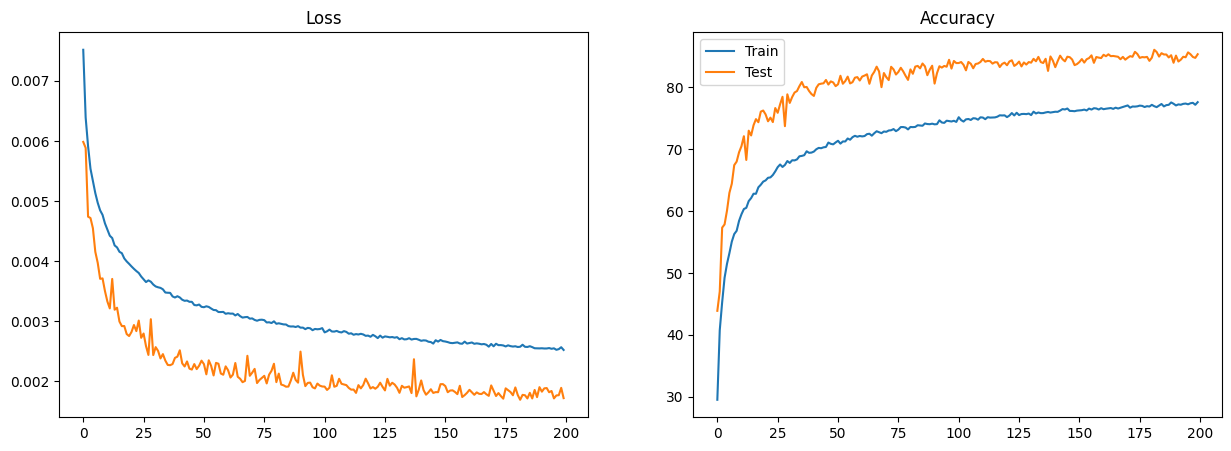

In [43]:
utils.plot_loss_accuracy([train_losses, test_losses, train_accs, test_accs], 'results/Loss.png')

# Mis-classified cases


In [22]:
test_images = [item[0] for item in test_loader.dataset][:500]
test_images = torch.stack(test_images)
test_targets = torch.tensor(test_loader.dataset.targets).to(device)[:500]

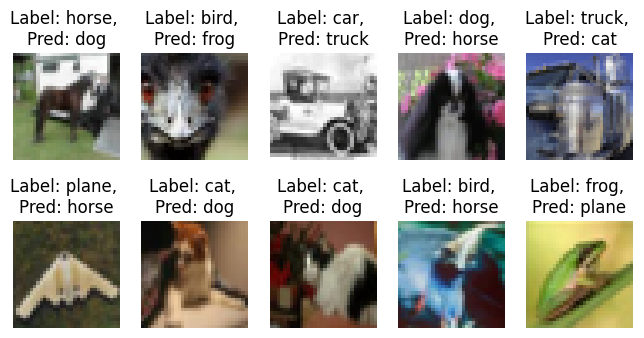

In [23]:
test_predictions = model(test_images.to(device))
wrong = utils.classfication_result(test_predictions, test_targets, device, b=False).cpu()

utils.plot_grid(test_images[wrong], test_targets[wrong], UnNorm, test_predictions[wrong],'results/misclassified.png')